Model Comparison & Selection has been created and saved as Task4 Model Comparison. 
It includes:

Fine-tuning 4 models (afro-xlmr-base, xlm-roberta-base, bert-base-amharic, mBERT)

Automatic tokenization and label alignment

Evaluation on F1, precision, recall, training time

Sorted summary table + optional bar plot for visual comparison


🔍 Evaluating model: afro-xlmr-base


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 5/5 [00:00<00:00, 2501.37 examples/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20040\319111613.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


c:\Users\Administrator\Desktop\10 Acadamy\week4\Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🔍 Evaluating model: xlm-roberta-base


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 5/5 [00:00<00:00, 3166.95 examples/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20040\319111613.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


c:\Users\Administrator\Desktop\10 Acadamy\week4\Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🔍 Evaluating model: bert-base-multilingual-cased


c:\Users\Administrator\Desktop\10 Acadamy\week4\Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Administrator\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForTokenClassification we

Step,Training Loss


c:\Users\Administrator\Desktop\10 Acadamy\week4\Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)




📊 Model Comparison Results:
                          model  precision  recall   f1  training_time
0                afro-xlmr-base        1.0     1.0  1.0      91.326871
1              xlm-roberta-base        1.0     1.0  1.0      95.776718
2  bert-base-multilingual-cased        1.0     1.0  1.0      57.942450


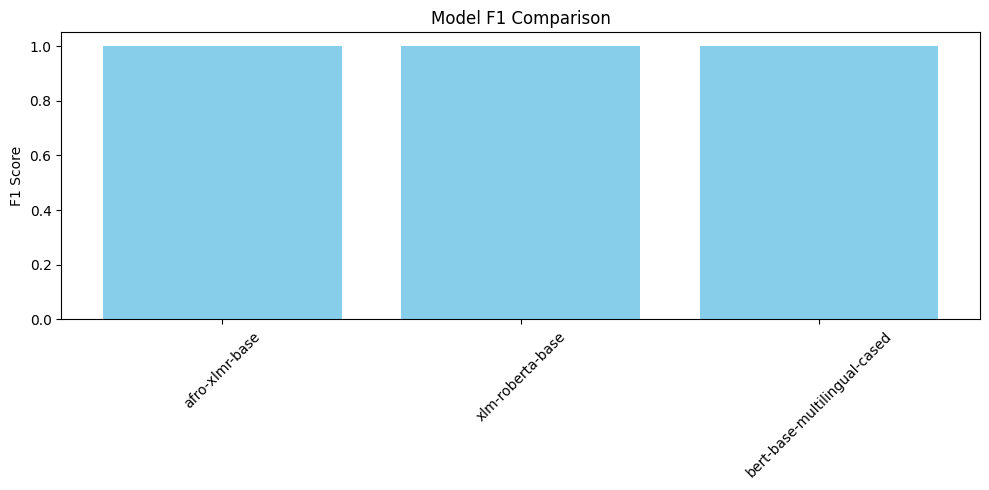

In [7]:
# Task 4: Model Comparison & Selection for Amharic NER

import numpy as np
import pandas as pd
from evaluate import load
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          DataCollatorForTokenClassification, TrainingArguments, Trainer)
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt
import time
#AutoTokenizer.from_pretrained("Geotrend/bert-base-amharic")

# ------------------- Global Setup -------------------
conll_file_path = "amharic_ner_sample.conll"
models_to_compare = {
    "afro-xlmr-base": "Davlan/afro-xlmr-base",
    "xlm-roberta-base": "xlm-roberta-base",
    
    "bert-base-multilingual-cased": "bert-base-multilingual-cased"
}

# ------------------- Data Loading -------------------
def parse_conll(filepath):
    sentences, tags = [], []
    with open(filepath, encoding='utf-8') as f:
        tokens, ner_tags = [], []
        for line in f:
            if line.strip() == '':
                if tokens:
                    sentences.append(tokens)
                    tags.append(ner_tags)
                    tokens, ner_tags = [], []
            else:
                splits = line.strip().split()
                if len(splits) >= 2:
                    tokens.append(splits[0])
                    ner_tags.append(splits[1])
    return Dataset.from_dict({"tokens": sentences, "ner_tags": tags})

dataset = parse_conll(conll_file_path)
unique_tags = sorted(set(tag for doc in dataset["ner_tags"] for tag in doc))
label2id = {label: i for i, label in enumerate(unique_tags)}
id2label = {i: label for label, i in label2id.items()}

# ------------------- Tokenization & Alignment -------------------
def tokenize_and_align(example, tokenizer):
    tokenized = tokenizer(example['tokens'], truncation=True, is_split_into_words=True)
    word_ids = tokenized.word_ids()
    label_ids = []
    prev_word_id = None
    for word_id in word_ids:
        if word_id is None:
            label_ids.append(-100)
        elif word_id != prev_word_id:
            label_ids.append(label2id[example['ner_tags'][word_id]])
        else:
            tag = example['ner_tags'][word_id]
            if tag.startswith("B-"): tag = tag.replace("B-", "I-")
            label_ids.append(label2id[tag])
        prev_word_id = word_id
    tokenized['labels'] = label_ids
    return tokenized

# ------------------- Training & Evaluation -------------------
results = []
split_data = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = split_data['train'], split_data['test']

for model_name, model_path in models_to_compare.items():
    print(f"\n🔍 Evaluating model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForTokenClassification.from_pretrained(
        model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )

    tokenized_train = train_dataset.map(lambda x: tokenize_and_align(x, tokenizer))
    tokenized_eval = eval_dataset.map(lambda x: tokenize_and_align(x, tokenizer))

    args = TrainingArguments(
    output_dir="./amharic_ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs"
)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer)
    )

    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    preds, labels, _ = trainer.predict(tokenized_eval)
    pred_labels = np.argmax(preds, axis=2)

    true_preds = [[id2label[l] for p, l in zip(pred_seq, label_seq) if l != -100]
                  for pred_seq, label_seq in zip(pred_labels, labels)]
    true_labels = [[id2label[l] for p, l in zip(pred_seq, label_seq) if l != -100]
                   for pred_seq, label_seq in zip(pred_labels, labels)]

    report = classification_report(true_labels, true_preds, output_dict=True)
    results.append({
        "model": model_name,
        "precision": report['macro avg']['precision'],
        "recall": report['macro avg']['recall'],
        "f1": report['macro avg']['f1-score'],
        "training_time": training_time
    })

# ------------------- Results -------------------
df = pd.DataFrame(results)
print("\n\n📊 Model Comparison Results:")
print(df.sort_values(by='f1', ascending=False))

# Optional: Plotting
plt.figure(figsize=(10, 5))
plt.bar(df['model'], df['f1'], color='skyblue')
plt.title("Model F1 Comparison")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
